In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [22]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [29]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cuda


In [30]:
#choppeddata=pd.read_csv('choppeddata_10_06_2021.csv')#.head()
choppeddata1=pd.read_csv('choppeddata_10_04_2021_equalsuccessfail.csv')#.head()
choppeddata2=pd.read_csv('choppeddata_10_06_2021_equalsuccessfail.csv')#.head()
print(choppeddata1.shape)
print(choppeddata2.shape)
frames = [choppeddata1, choppeddata2]
choppeddata = pd.concat(frames)
print(choppeddata.shape)

(1440, 10)
(3960, 10)
(5400, 10)


In [31]:
print(choppeddata.shape)
runqty=int(choppeddata.shape[0]/6)
print("total runs:",runqty)
choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((runqty,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((runqty,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata.shape[0],6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
#print(Labels[:,9]) #just getting finals labels

(5400, 10)
total runs: 900


In [34]:
#X= range(0,575,6)
#y= range(0,575,6)

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)

y=y.reshape(runqty,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                   random_state=random_seed)
#print("Train")
#print(train_x[0])
#print(train_y[0])
print("Test set Y size", test_x.size)
print("Train set Y size", train_y.size)
#print(test_x[0])
#print(test_y[0])
print("Test set C size", test_x.size)
print("Test set Y size", test_y.size)

x.shape (900, 5, 10)
Test set Y size 11250
Train set Y size 675
Test set C size 11250
Test set Y size 225


We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

In [35]:
batch_size = 4
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )
print(train_loader)

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [49]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model

def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []  #labels
    start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE                               

def evaluatefull(model, train_x, train_y, test_x, test_y,maxdifference=0.2, verbose=False):

    m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    print("Vs Training Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)


    #print("Train size:",trainy.size)
    print(gru_outputs[0][4])
    train_successcounter=0
    for i in range(int(trainy.size)):
        #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
        #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))


        #print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))


        if abs(trainy[i]-gru_outputs[0][i])<maxdifference :
            train_successcounter+=1
        #print(testy[i])
        #print
        #output = m(input)



    test_successcounter=0
    print("Vs Test Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    #print("test size: ",testy.size)

    for i in range(int(testy.size)):


        #, m(torch.tensor(gru_outputs[0][i])))


        if abs(testy[i]-gru_outputs[0][i])<maxdifference :
            test_successcounter+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK" )
        else:
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X" )
            #print(testy[i])
        #print
        #output = m(input)
    print("")
    print(" vs training data=" ,train_successcounter,"/",trainy.size, " vs test data=" ,
          test_successcounter,"/",testy.size,int(100*test_successcounter/testy.size),"%", "at max difference",maxdifference )
    return ( train_successcounter ,test_successcounter)




x.shape (900, 5, 10)
Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/400 Done, Total Loss: 0.061010586615108574   Time Elapsed: 0.3042769999999564 seconds
Epoch 80/400 Done, Total Loss: 0.037366006078276164   Time Elapsed: 0.34058500000014647 seconds
Epoch 120/400 Done, Total Loss: 0.02757260898826644   Time Elapsed: 0.3830950000001394 seconds
Epoch 160/400 Done, Total Loss: 0.01637447804765543   Time Elapsed: 0.3086359999999786 seconds
Epoch 200/400 Done, Total Loss: 0.01506460979639087   Time Elapsed: 0.3097660000000815 seconds
Epoch 240/400 Done, Total Loss: 0.010970189336997766   Time Elapsed: 0.3099130000000514 seconds
Epoch 280/400 Done, Total Loss: 0.008359604530148014   Time Elapsed: 0.31028700000001663 seconds
Epoch 320/400 Done, Total Loss: 0.006591568182047922   Time Elapsed: 0.3121299999997973 seconds
Epoch 360/400 Done, Total Loss: 0.009990621258160293   Time Elapsed: 0.30319200000008095 seconds
Epoch 400/400 Done, Total Loss: 0.008806980607526688   Time Elapsed: 0.37629400000014357 seconds
Total Training Time: 129.3300239999994 se

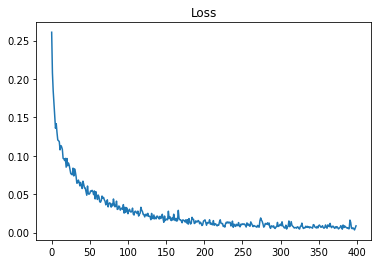

Vs Training Set
Evaluation Time: 0.0016229999998813582
sMAPE: -2.8038157915817243%
0.03436061
Vs Test Set
Evaluation Time: 0.001044999999976426
sMAPE: 8.576353202037854%

 vs training data= 600 / 603  vs test data= 227 / 297 76 % at max difference 0.2
Vs Training Set
Evaluation Time: 0.0017629999999826396
sMAPE: -2.8038157915817243%
0.03436061
Vs Test Set
Evaluation Time: 0.0010530000001836015
sMAPE: 8.576353202037854%

 vs training data= 601 / 603  vs test data= 245 / 297 82 % at max difference 0.3
Vs Training Set
Evaluation Time: 0.0025709999999889988
sMAPE: -2.8038157915817243%
0.03436061
Vs Test Set
Evaluation Time: 0.0009700000000520959
sMAPE: 8.576353202037854%

 vs training data= 601 / 603  vs test data= 252 / 297 84 % at max difference 0.4
Vs Training Set
Evaluation Time: 0.001767999999856329
sMAPE: -2.8038157915817243%
0.03436061
Vs Test Set
Evaluation Time: 0.0013589999998657731
sMAPE: 8.576353202037854%

 vs training data= 603 / 603  vs test data= 257 / 297 86 % at max diffe

/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:130: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [44]:
lr = 0.001
batch_size = 4
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)
y=y.reshape(runqty,1)


random_seed=int(time.time())
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.33, #0.33, 
                                                   random_state=random_seed)

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )


gru_model = train(train_loader, lr , hidden_dim=128, EPOCHS=400, model_type="GRU")
train2 ,test2=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.2)
train3 ,test3=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.3)
train4 ,test4=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.4)
train5 ,test5=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.5)



In [47]:
lr = 0.001
batch_size = 4
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)
y=y.reshape(runqty,1)



#print(int(time.time()))

trainlist2=[]
testlist2=[]
trainlist3=[]
testlist3=[]
trainlist4=[]
testlist4=[]
trainlist5=[]
testlist5=[]

trainlist2b=[]
testlist2b=[]
trainlist3b=[]
testlist3b=[]
trainlist4b=[]
testlist4b=[]
trainlist5b=[]
testlist5b=[]
test_size=.25
for i in range(5):
    random_seed=int(time.time())
    train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                       random_state=random_seed)

    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
    test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )


    gru_model = train(train_loader, lr , hidden_dim=128, EPOCHS=400, model_type="GRU")
    train2 ,test2=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.2)
    train3 ,test3=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.3)
    train4 ,test4=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.4)
    train5 ,test5=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.5)
    trainlist2.append(train2)
    testlist2.append(test2)
    trainlist3.append(train3)
    testlist3.append(test3)
    trainlist4.append(train4)
    testlist4.append(test4)
    trainlist5.append(train5)
    testlist5.append(test5)
 




test_size=.33
for i in range(5):
    random_seed=int(time.time())
    train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.33, #0.33, 
                                                       random_state=random_seed)

    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
    test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )


    gru_model = train(train_loader, lr , hidden_dim=128, EPOCHS=400, model_type="GRU")
    train2 ,test2=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.2)
    train3 ,test3=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.3)
    train4 ,test4=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.4)
    train5 ,test5=evaluatefull(gru_model, train_x, train_y, test_x, test_y,maxdifference=.5)
    trainlist2b.append(train2)
    testlist2bappend(test2)
    trainlist3b.append(train3)
    testlist3b.append(test3)
    trainlist4b.append(train4)
    testlist4b.append(test4)
    trainlist5b.append(train5)
    testlist5b.append(test5)

    
print("at test_size= .25 : ")
print("trainlist2",trainlist2)
print("trainlist3",trainlist3)
print("trainlist4",trainlist4)
print("trainlist5",trainlist5)

print("testlist2",testlist2)
print("testlist3",testlist3)
print("testlist4",testlist4)
print("testlist5",testlist5)

print("at test_size=.33 : ")
print("trainlist2",trainlist2b)
print("trainlist3",trainlist3b)
print("trainlist4",trainlist4b)
print("trainlist5",trainlist5b)

print("testlist2",testlist2b)
print("testlist3",testlist3b)
print("testlist4",testlist4b)
print("testlist5",testlist5b)
 

#vs training data= 490 / 495  vs test data= 128 / 165 (77%) from 128 hidden dim,  batch size of 4, lr =0.001,test_size=.25,  400 epoch
#vs training data= 492 / 495  vs test data= 130 / 165 (78%) from 128 hidden dim,  batch size of 4, lr =0.0005,test_size=.25,  400 epoch
#vs training data= 411 / 495  vs test data= 103 / 165 62%) from 128 hidden dim,  batch size of 4, lr =0.0001,test_size=.25,  400 epoch
#vs training data= 451 / 495  vs test data= 113 / 165 68%) from 128 hidden dim,  batch size of 4, lr =0.0001,test_size=.25,  600 epoch
#vs training data= 472 / 495  vs test data= 133 / 165 80%) from 128 hidden dim,  batch size of 4, lr =0.002,test_size=.25,  600 epoch


#vs training data= 472 / 495  vs test data= 133 / 165 80%) from 128 hidden dim,  batch size of 4, lr =0.002,test_size=.25,  400 epoch
#vs training data= 487 / 495  vs test data= 134 / 165 81% at 0.2 cuttoff
 #vs training data= 490 / 495  vs test data= 142 / 165 86.06060606060606 % at 0.3 cuttoff
 # vs training data= 491 / 495  vs test data= 146 / 165 88.48484848484848 % at 0.4 cuttoff






#With full data set (uneven amts of success/fail) from 128 hidden dim,  batch size of 4, lr =0.0005,test_size=.25,  400 epoch
#vs training data= 893 / 900  vs test data= 227 / 300 75 % at max difference 0.2
# vs training data= 898 / 900  vs test data= 238 / 300 79 % at max difference 0.3
# vs training data= 900 / 900  vs test data= 240 / 300 80 % at max difference 0.4
# vs training data= 900 / 900  vs test data= 243 / 300 81 % at max difference 0.5


#with even success/fail amounts (10-6):

# vs training data= 494 / 495  vs test data= 131 / 165 79 % at max difference 0.2
# vs training data= 495 / 495  vs test data= 138 / 165 83 % at max difference 0.3
# vs training data= 495 / 495  vs test data= 140 / 165 84 % at max difference 0.4
# vs training data= 495 / 495  vs test data= 144 / 165 87 % at max difference 0.5

#with even success/fail amounts (10-4 and 10-6): (batch size of 4
# vs training data= 653 / 675  vs test data= 168 / 225 74 % at max difference 0.2
#vs training data= 663 / 675  vs test data= 180 / 225 80 % at max difference 0.3
# vs training data= 667 / 675  vs test data= 189 / 225 84 % at max difference 0.4
#vs training data= 670 / 675  vs test data= 196 / 225 87 % at max difference 0.5

#with even success/fail amounts (10-4 and 10-6) (batch size of 8):
# vs training data= 670 / 675  vs test data= 174 / 225 77 % at max difference 0.2
# vs training data= 673 / 675  vs test data= 190 / 225 84 % at max difference 0.3
# vs training data= 675 / 675  vs test data= 191 / 225 84 % at max difference 0.4
# vs training data= 675 / 675  vs test data= 193 / 225 85 % at max difference 0.5

#with even success/fail amounts (10-4 and 10-6) (batch size of 2):
# vs training data= 662 / 675  vs test data= 178 / 225 79 % at max difference 0.2
# vs training data= 673 / 675  vs test data= 186 / 225 82 % at max difference 0.3
# vs training data= 673 / 675  vs test data= 191 / 225 84 % at max difference 0.4
# vs training data= 674 / 675  vs test data= 199 / 225 88 % at max difference 0.5

#with even success/fail amounts (10-4 and 10-6) (batch size of 2, lr=0.0005):
# vs training data= 673 / 675  vs test data= 175 / 225 77 % at max difference 0.2
# vs training data= 674 / 675  vs test data= 189 / 225 84 % at max difference 0.3
# vs training data= 674 / 675  vs test data= 197 / 225 87 % at max difference 0.4
# vs training data= 675 / 675  vs test data= 204 / 225 90 % at max difference 0.5

#with even success/fail amounts (10-4 and 10-6) (batch size of 4, lr=0.002):
# vs training data= 588 / 675  vs test data= 175 / 225 77 % at max difference 0.2
#vs training data= 626 / 675  vs test data= 187 / 225 83 % at max difference 0.3
## vs training data= 637 / 675  vs test data= 197 / 225 87 % at max difference 0.4
# vs training data= 648 / 675  vs test data= 204 / 225 90 % at max difference 0.5

#The target size means the label size!

x.shape (900, 5, 10)
Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


KeyboardInterrupt: 

In [50]:
def evaluate_episode(model, data,  maxdifference=0.2, verbose=False):

   
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    print("model output",out)
    return out

In [60]:
#print(train_x[0])
print(train_x[0].shape)


exampledata=np.expand_dims(train_x[0], axis=0)

print(exampledata.shape)
evaluate_episode(gru_model, exampledata)
print("actual",train_y[0])

(5, 10)
(1, 5, 10)
model output tensor([[1.0033]], device='cuda:0', grad_fn=<AddmmBackward>)
actual [1.]


In [ ]:
model=gru_model
i=1
inp = torch.from_numpy(np.array(test_x))
labs = torch.from_numpy(np.array(test_y))
#h = model.init_hidden(inp.shape[0])
h = model.init_hidden(inp.shape[0])
#print("inp",inp)

#print("INP SHAPE",inp.shape)
#print("INP SHAPE[0]",inp.shape[0])
#print("labs",labs)
#print("h",h)
#print("h.shape",h.shape)
#print(inp.to(device).float())
#print(inp.to(device).float().shape)
print(inp.to(device).float().shape)

out, h = model(inp.to(device).float(), h)
#print(out)

In [ ]:
#print(test_y.reshape(-1))
